In [1]:
import re
import time
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("PROMISE.csv",encoding='latin1')
df.head(2)

,ProjectID,RequirementText,_class_
0,1,The system shall refresh the display every 60 ...,PE
1,1,The application shall match the color of the s...,LF


False
(969, 2)


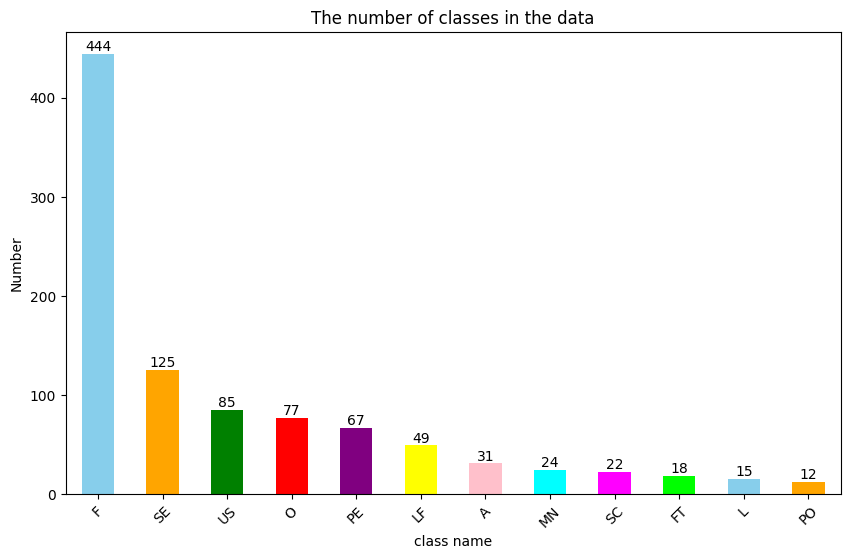

Number Of Contractions 5


,RequirementText,_class_,contraction_count,text
0,The system shall refresh the display every 60 ...,PE,0,system shall refresh display every 60 seconds
1,The application shall match the color of the s...,LF,0,application shall match color schema set forth...


In [3]:
columns = ['RequirementText', '_class_']
df = df[columns].copy()

print(df["RequirementText"].isnull().values.any())
df.dropna(axis = 0 , inplace = True)
print(df.shape)

class_counts = df["_class_"].value_counts()
class_counts_sorted = class_counts.sort_values(ascending=False)
colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'lime']
plt.figure(figsize=(10,6))
bars = class_counts_sorted.plot(kind='bar', color=colors)
for bar, value in zip(bars.patches, class_counts_sorted.values):
    bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, value, ha='center', va='bottom')

plt.title('The number of classes in the data')
plt.xlabel('class name')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.show()

import contractions

def count_contractions(text):
    contractions_pattern = re.compile(r"\b(?:{})\b".format("|".join(contractions.contractions_dict.keys())), flags=re.IGNORECASE)
    matches = contractions_pattern.findall(text)
    return len(matches)

df['contraction_count'] = df['RequirementText'].apply(count_contractions)
column_sum = df['contraction_count'].sum()
print("Number Of Contractions " + str(column_sum))

def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['RequirementText'].apply(expand_contractions)

df['text'] = df['text'].str.lower()


df['text'] = df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))


from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ', x))
df.head(2)             

In [4]:
from transformers import BertModel, BertTokenizer
model = BertModel.from_pretrained('bert-base-uncased')
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = bertTokenizer.vocab_size
print("Vocabulary Size:", vocab_size)
def tokenize_text(text):
    tokens =bertTokenizer.tokenize(text) 
    return tokens

df['Tokenized_Text'] = df['text'].apply(tokenize_text)
df.head()
def Convert_Tokens_To_Ids(tokens):
    input_ids = bertTokenizer.convert_tokens_to_ids(tokens)
    return input_ids

df['Tokens_Ids'] = df['Tokenized_Text'].apply(Convert_Tokens_To_Ids)
df.head()
df.to_csv('Ids_BERT_nfr.csv', index=False)

C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Vocabulary Size: 30522


In [5]:
df = pd.read_csv("Ids_BERT_nfr.csv",encoding='latin1')
df.head(2)

,RequirementText,_class_,contraction_count,text,Tokenized_Text,Tokens_Ids
0,The system shall refresh the display every 60 ...,PE,0,system shall refresh display every 60 seconds,"['system', 'shall', 'ref', '##resh', 'display'...","[2291, 4618, 25416, 21898, 4653, 2296, 3438, 3..."
1,The application shall match the color of the s...,LF,0,application shall match color schema set forth...,"['application', 'shall', 'match', 'color', 'sc...","[4646, 4618, 2674, 3609, 8040, 28433, 2275, 57..."


In [6]:
import ast
def Convert_StrIds_To_ListIds(string_list):
    actual_list = ast.literal_eval(string_list)
    return actual_list

# Apply the function to the 'Tokens_Ids' column in the DataFrame
tqdm.pandas()  # Enable progress bar for pandas operations

df['Tokens_Ids'] = df['Tokens_Ids'].progress_apply(Convert_StrIds_To_ListIds)
df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████| 969/969 [00:00<00:00, 14047.89it/s]


,RequirementText,_class_,contraction_count,text,Tokenized_Text,Tokens_Ids
0,The system shall refresh the display every 60 ...,PE,0,system shall refresh display every 60 seconds,"['system', 'shall', 'ref', '##resh', 'display'...","[2291, 4618, 25416, 21898, 4653, 2296, 3438, 3..."
1,The application shall match the color of the s...,LF,0,application shall match color schema set forth...,"['application', 'shall', 'match', 'color', 'sc...","[4646, 4618, 2674, 3609, 8040, 28433, 2275, 57..."


In [7]:
import torch
from transformers import BertModel, BertTokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from tqdm import tqdm

def Convert_IDs_To_Vector(input_ids):
    global count
    
    # Check if input_ids is empty
    if not input_ids:
        print("Input_ids is empty."+ str(count))
        return None
    
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs.last_hidden_state[0].tolist()
    
        return embeddings

# Use tqdm to show progress bar while applying the function to each row
tqdm.pandas()

# Apply the function to each row and assign the result to a new column
df['Tokens_vectors'] = df['Tokens_Ids'].progress_apply(Convert_IDs_To_Vector)
df.head()


C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 969/969 [05:58<00:00,  2.70it/s]


,RequirementText,_class_,contraction_count,text,Tokenized_Text,Tokens_Ids,Tokens_vectors
0,The system shall refresh the display every 60 ...,PE,0,system shall refresh display every 60 seconds,"['system', 'shall', 'ref', '##resh', 'display'...","[2291, 4618, 25416, 21898, 4653, 2296, 3438, 3...","[[0.08623089641332626, 0.382962167263031, 0.31..."
1,The application shall match the color of the s...,LF,0,application shall match color schema set forth...,"['application', 'shall', 'match', 'color', 'sc...","[4646, 4618, 2674, 3609, 8040, 28433, 2275, 57...","[[-0.2534845769405365, 0.1357555389404297, 0.4..."
2,If projected the data must be readable. On a...,US,0,projected data must readable 10x10 projection ...,"['projected', 'data', 'must', 'read', '##able'...","[11310, 2951, 2442, 3191, 3085, 2184, 2595, 10...","[[-0.2657283842563629, 0.12998726963996887, 0...."
3,The product shall be available during normal b...,A,0,product shall available normal business hours ...,"['product', 'shall', 'available', 'normal', 'b...","[4031, 4618, 2800, 3671, 2449, 2847, 2146, 531...","[[-0.24570393562316895, 0.43557193875312805, 0..."
4,If projected the data must be understandable....,US,0,projected data must understandable 10x10 proje...,"['projected', 'data', 'must', 'understand', '#...","[11310, 2951, 2442, 3305, 3085, 2184, 2595, 10...","[[-0.3270963728427887, 0.2892795503139496, 0.1..."


In [8]:
import re
import ast
import time
import torch
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from keras.models import Sequential
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Flatten, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.utils import to_categorical

Shape of X_train: (775, 57, 768)
Epoch 1/50
13/13 [==============================] - 10s 659ms/step - loss: 2.0438 - accuracy: 0.4077 - val_loss: 1.7435 - val_accuracy: 0.4691
Epoch 2/50
13/13 [==============================] - 8s 629ms/step - loss: 1.5786 - accuracy: 0.4852 - val_loss: 1.6113 - val_accuracy: 0.4897
Epoch 3/50
13/13 [==============================] - 8s 611ms/step - loss: 1.2627 - accuracy: 0.5948 - val_loss: 1.5790 - val_accuracy: 0.4691
Epoch 4/50
13/13 [==============================] - 8s 631ms/step - loss: 0.9909 - accuracy: 0.6852 - val_loss: 1.8567 - val_accuracy: 0.4072
Epoch 5/50
13/13 [==============================] - 9s 721ms/step - loss: 0.8277 - accuracy: 0.7342 - val_loss: 1.3843 - val_accuracy: 0.5979
Epoch 6/50
13/13 [==============================] - 9s 658ms/step - loss: 0.4783 - accuracy: 0.8529 - val_loss: 1.7526 - val_accuracy: 0.5979
Epoch 7/50
13/13 [==============================] - 8s 616ms/step - loss: 0.2478 - accuracy: 0.9290 - val_loss: 1.

C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 [==============================] - 3s 124ms/step
Train Precision: 1.0
Train Recall: 1.0
Train F-Measure: 1.0


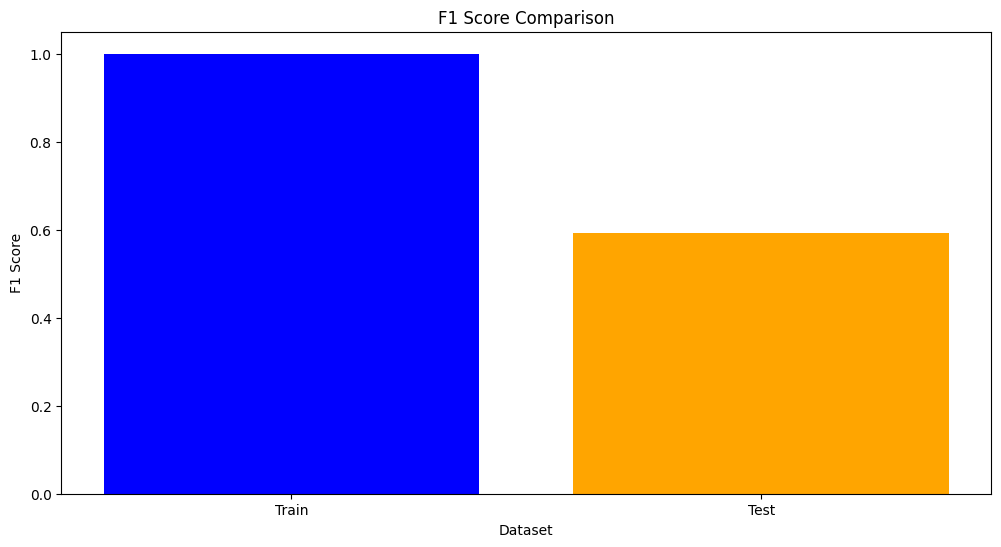

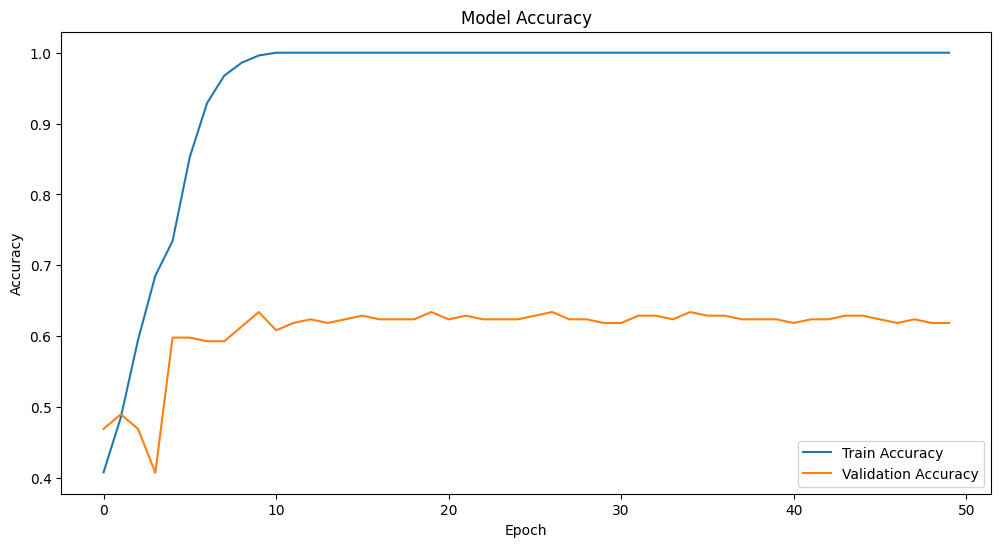

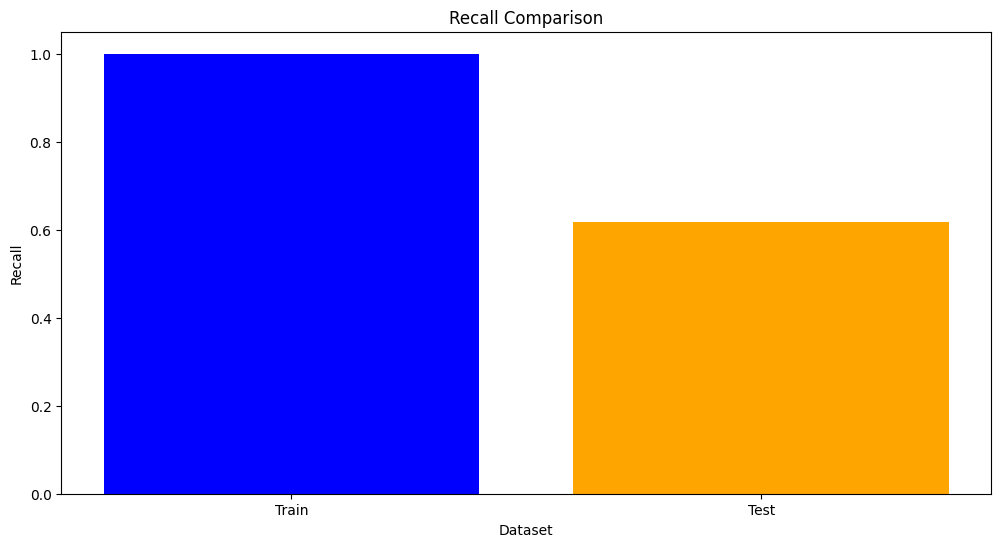

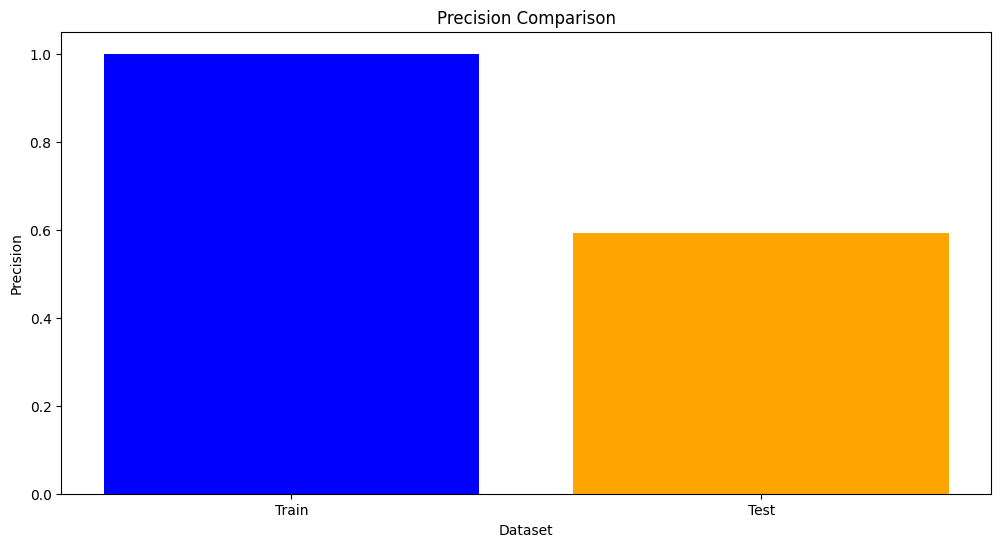

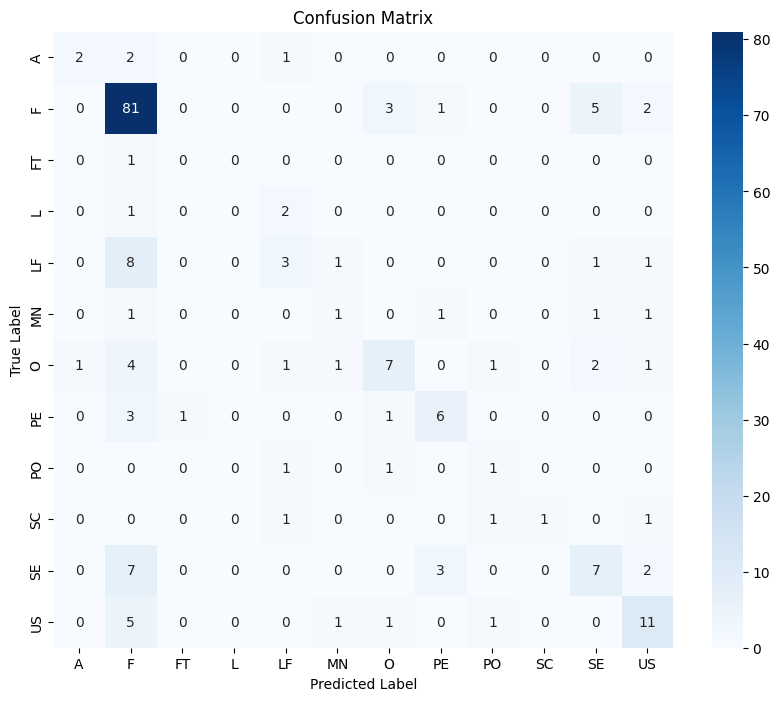

Classification Report for each class:
              precision    recall  f1-score   support

           A       0.67      0.40      0.50         5
           F       0.72      0.88      0.79        92
          FT       0.00      0.00      0.00         1
           L       0.00      0.00      0.00         3
          LF       0.33      0.21      0.26        14
          MN       0.25      0.20      0.22         5
           O       0.54      0.39      0.45        18
          PE       0.55      0.55      0.55        11
          PO       0.25      0.33      0.29         3
          SC       1.00      0.25      0.40         4
          SE       0.44      0.37      0.40        19
          US       0.58      0.58      0.58        19

    accuracy                           0.62       194
   macro avg       0.44      0.35      0.37       194
weighted avg       0.59      0.62      0.59       194



C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Amani-System\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['_class_'])

# تعداد کلاس‌ها
num_classes = df['label'].nunique()

# Convert text data to feature vectors
X = pad_sequences(df['Tokens_vectors'].values, padding='post',dtype='float32')

# Convert labels to categorical data
y = df['label']
y = to_categorical(y, num_classes)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Random State = 0

print("Shape of X_train:", X_train.shape)

# Add an extra dimension of size 1 to the data (for Conv1D)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Define the CNN model
model = Sequential([
    Conv1D(768, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(50, padding='same'),
    Conv1D(768, 2, activation='relu'),
    MaxPooling1D(10, padding='same'),
    Flatten(),
    Dense(768, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Predict on test data
y_pred_test = model.predict(X_test)

# Convert predictions to labels
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F-measure for test data
precision_test = precision_score(y_test_labels, y_pred_test_labels, average='weighted')
recall_test = recall_score(y_test_labels, y_pred_test_labels, average='weighted')
f1_test = f1_score(y_test_labels, y_pred_test_labels, average='weighted')

print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F-Measure:", f1_test)

# Predict on train data
y_pred_train = model.predict(X_train)

# Convert predictions to labels
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

# Calculate precision, recall, and F-measure for train data
precision_train = precision_score(y_train_labels, y_pred_train_labels, average='weighted')
recall_train = recall_score(y_train_labels, y_pred_train_labels, average='weighted')
f1_train = f1_score(y_train_labels, y_pred_train_labels, average='weighted')

print("Train Precision:", precision_train)
print("Train Recall:", recall_train)
print("Train F-Measure:", f1_train)

# Plotting F1 Score for Train and Test sets
plt.figure(figsize=(12, 6))
plt.bar(['Train', 'Test'], [f1_train, f1_test], color=['blue', 'orange'])
plt.title('F1 Score Comparison')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.savefig('f1_score_comparison.png')
plt.show()

# Plotting Accuracy for Train and Test sets
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('model_accuracy.png')
plt.show()

# Plotting Recall for Train and Test sets
plt.figure(figsize=(12, 6))
plt.bar(['Train', 'Test'], [recall_train, recall_test], color=['blue', 'orange'])
plt.title('Recall Comparison')
plt.xlabel('Dataset')
plt.ylabel('Recall')
plt.savefig('recall_comparison.png')
plt.show()

# Plotting Precision for Train and Test sets
plt.figure(figsize=(12, 6))
plt.bar(['Train', 'Test'], [precision_train, precision_test], color=['blue', 'orange'])
plt.title('Precision Comparison')
plt.xlabel('Dataset')
plt.ylabel('Precision')
plt.savefig('precision_comparison.png')
plt.show()

# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_test_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report for each class
print("Classification Report for each class:")
report = classification_report(y_test_labels, y_pred_test_labels, target_names=label_encoder.classes_)
print(report)

# Save classification report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)
